# Simulate sinusoidal data and fit it with MCMC

In [1]:
%matplotlib inline
import emcee
import numpy as np
from matplotlib import pyplot

### Simulate some linear data

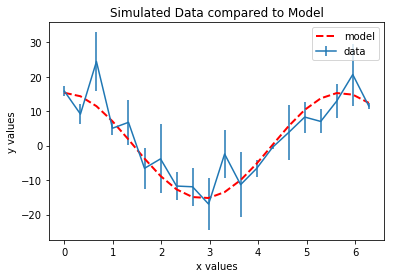

In [2]:
# magnitude
a = 15.33
# frequency (rad/s)
w = 1.1
# number of data points to simulate
num_data_points = 20
# error in measurements (different data has different error)
y_data_err = np.array([0.5*(x+1) for x in range(num_data_points)])
#set the seed for reproducibility
np.random.seed(2222)
np.random.shuffle(y_data_err)
# mean of "noise" in the measurement
mean = np.zeros((num_data_points))
# covariance of data
covar = np.zeros((num_data_points,num_data_points))
for i in range(num_data_points):
    covar[i,i] = y_data_err[i]**2

# simulate data
x_data = np.linspace(0, 2*np.pi, num=num_data_points)
np.random.seed(42)
y_model = a*np.cos(w*x_data)
y_data = y_model + np.random.multivariate_normal(mean,covar)

# plot data and ideal model
fig = pyplot.figure()
ax = fig.add_subplot(111)
ax.errorbar(x_data,y_data,yerr=y_data_err,label='data')
ax.plot(x_data,y_model,'r--',lw=2,label='model')
ax.set_title('Simulated Data compared to Model')
ax.set_xlabel('x values')
ax.set_ylabel('y values')
ax.legend()

### Set up the prior, likelihood, and posterior distribution functions

In [3]:
# Work in log probability space

# log prior
def lnprior(theta):
    magnitude, frequency = theta
    if -np.inf < magnitude < np.inf and -np.pi < frequency < np.pi:
        return 0.0
    return -np.inf

# log likelihood function
def lnlike(theta, x, y, yerr):
    magnitude, frequency = theta
        
    model = magnitude*np.cos(frequency*x)
    chi_squared = np.sum((y-model)**2/yerr**2)

    return -0.5*chi_squared

# log probability function
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

### Now some emcee! Setup the Ensemble Sampler and run it

In [4]:
#Set up some walkers in a gaussian ball around the maximum likelyhood result
num_params, num_walkers = 2, 100
# initial positions of the walkers
pos = [np.random.randn(num_params) for i in range(num_walkers)]
# set up the sampler
sampler = emcee.EnsembleSampler(num_walkers, num_params, lnprob, args=(x_data,y_data,y_data_err))
#and send it on a walk
sampler.reset()
num_steps = 1500
pos0, prob, state = sampler.run_mcmc(pos, num_steps)

/home/asreimer/virtualenvs/env3.7/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/asreimer/virtualenvs/env3.7/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


### And plot the paths of the walkers

Text(0.5, 0, 'step number')

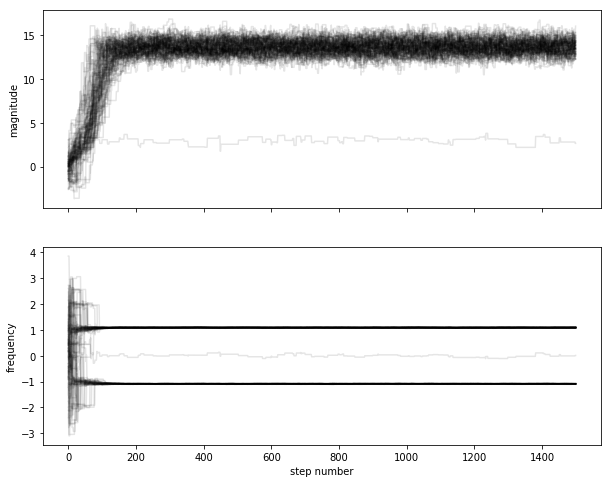

In [5]:
#Plot the "path" of the walkers
xs = np.arange(0,num_steps)

fig = pyplot.figure(figsize=(10,8))
ax = fig.add_subplot(211)
for i in range(num_walkers):
    ax.plot(xs, sampler.chain[i,:,0],'black',alpha=0.1)
ax.set_ylabel('magnitude')
ax.set_xticklabels([])
ax = fig.add_subplot(212)
for i in range(num_walkers):
    ax.plot(xs, sampler.chain[i,:,1],'black',alpha=0.1)
ax.set_ylabel('frequency')
ax.set_xlabel('step number')

### Generate the Posterior distribution

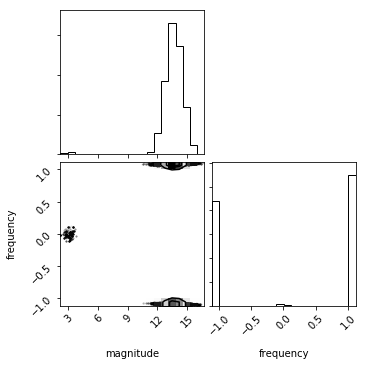

In [6]:
# Now let's plot a triangle plot
# But notice that there's a "burn in" period before the walkers converged
# so we'll skip 500 samples and only use the remaining
samples = sampler.chain[:, 500:, :].reshape((-1, num_params))

import corner
fig = corner.corner(samples, labels=["magnitude", "frequency", "intercept"])
fig.savefig("triangle.eps")

### A surprisingly expected result!

The multiple peaks in frequency are explained by remembering that cos(x) = cos(-x)

To converge to a solution, we need to modify our a priori! Specifically by restricting it:
    - only positive frequency
    
There is a small probability of the magnitude being ~4 and frequency being 0 due to error in the data.

We can also use the mean from the first attempt as an initial starting point for the next walk!

In [7]:
# log prior
def lnprior(theta):
    magnitude, frequency = theta
    if -np.inf < magnitude < np.inf and 0 <= frequency < np.pi:
        return 0.0
    return -np.inf

Text(0.5, 0, 'step number')

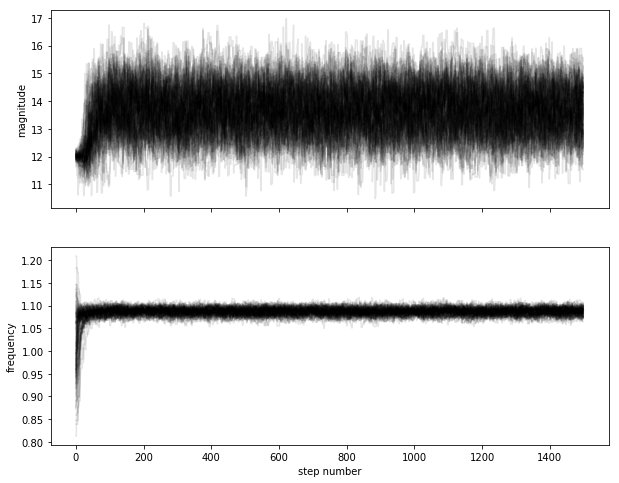

In [8]:
#Set up some walkers in a gaussian ball around the maximum likelyhood result
num_params, num_walkers = 2, 100
# initial positions of the walkers
pos = [np.array([12,1]) + np.random.randn(num_params)/10. for i in range(num_walkers)]
# set up the sampler
sampler = emcee.EnsembleSampler(num_walkers, num_params, lnprob, args=(x_data,y_data,y_data_err))
#and send it on a walk
sampler.reset()
num_steps = 1500
pos0, prob, state = sampler.run_mcmc(pos, num_steps)

#Plot the "path" of the walkers
xs = np.arange(0,num_steps)
fig = pyplot.figure(figsize=(10,8))
ax = fig.add_subplot(211)
for i in range(num_walkers):
    ax.plot(xs, sampler.chain[i,:,0],'black',alpha=0.1)
ax.set_ylabel('magnitude')
ax.set_xticklabels([])
ax = fig.add_subplot(212)
for i in range(num_walkers):
    ax.plot(xs, sampler.chain[i,:,1],'black',alpha=0.1)
ax.set_ylabel('frequency')
ax.set_xlabel('step number')

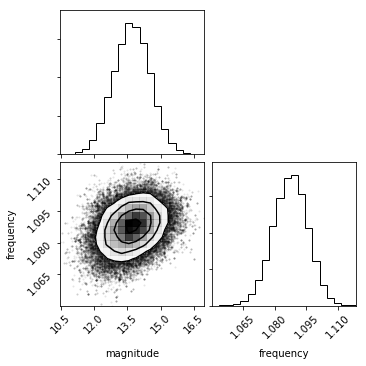

In [9]:
# Now let's plot a triangle plot
# But notice that there's a "burn in" period before the walkers converged
# so we'll skip 400 samples and only use the remaining
samples = sampler.chain[:, 400:, :].reshape((-1, num_params))

import corner
fig = corner.corner(samples, labels=["magnitude", "frequency", "intercept"])
fig.savefig("triangle.eps")

In [10]:
# Grab the mean for each parameter and the 1-sigma errorbar
magnitude_mcmc, frequency_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                     zip(*np.percentile(samples, [16, 50, 84],
                                                        axis=0)))

print('Model magnitude: {:1.5f}'.format(a))
print('Fitted magnitude: {:1.5f} +{:1.5f} -{:1.5f}'.format(magnitude_mcmc[0],magnitude_mcmc[1],magnitude_mcmc[2]))
print('Model frequency: {:1.5f}'.format(w))
print('Fitted frequency: {:1.5f} +{:1.5f} -{:1.5f}'.format(frequency_mcmc[0],frequency_mcmc[1],frequency_mcmc[2]))

Model magnitude: 15.33000
Fitted magnitude: 13.69519 +0.81166 -0.83275
Model frequency: 1.10000
Fitted frequency: 1.08750 +0.00791 -0.00829


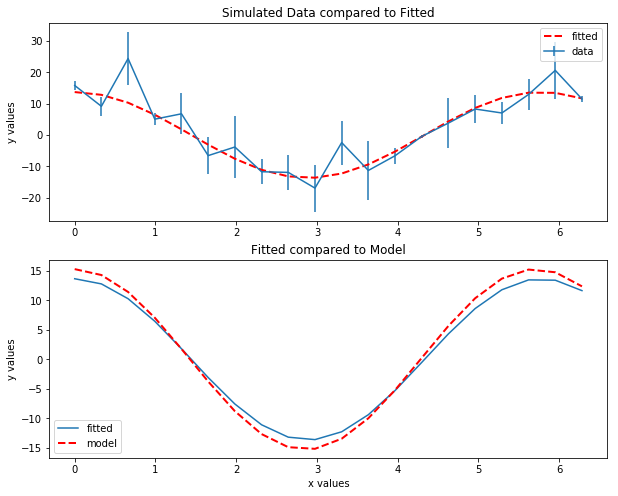

In [11]:
# plot data, ideal model, and fit
y_fitted = magnitude_mcmc[0] * np.cos(frequency_mcmc[0]*x_data)

fig = pyplot.figure(figsize=(10,8))
ax = fig.add_subplot(211)
ax.errorbar(x_data,y_data,yerr=y_data_err,label='data')
ax.plot(x_data,y_fitted,'r--',lw=2,label='fitted')
ax.set_title('Simulated Data compared to Fitted')
ax.set_ylabel('y values')
ax.legend()
ax = fig.add_subplot(212)
ax.plot(x_data,y_fitted,label='fitted')
ax.plot(x_data,y_model,'r--',lw=2,label='model')
ax.set_title('Fitted compared to Model')
ax.set_xlabel('x values')
ax.set_ylabel('y values')
ax.legend()
